<h3> Анализ оттока клиентов "Метанпромбанк" <a class="tocSkip"> </h3>
    
**Цель проекта:** Проанализировать клиентов регионального банка и выделить сегменты клиентов,
которые склонны уходить из банка.
    
**Входные данные:** данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.
    
**Работа состоит из:**
* Загрузки данных, ознакомления с ними;
* Предобработки данных;
* Исследовательского анализа данных;
* Проверки статистических гипотез;
* Определения признаков отточности, формирования сегметов и рекомендации по лучшим из них.
        
*Проект подготовил: Мамаев П.Р.*

## Загрузка данных

### Подключение библиотек

In [1]:
import pandas as pd
import os
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

### Загрузка данных

In [2]:
bank = '/datasets/bank_scrooge.csv'

### Изучение общей информации

In [3]:
bank.head(10)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
8,211686,923.0,Ярославль,М,54.0,5,1206337.87,2,1,0,155371.79,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0


In [4]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


1) В целом, в наших данных 10000 строк. 2 столбца из 12 заполнены неполностью - нет 26 значений в столбце с возрастом чуть более 2000 пропусков в столбце с текущим балансом на счёте клиента. Это количественные значения.

2) Названия некоторых столбцов необходимо унифицировать и привести к нижнему регистру для удобства работы и чтения.

3) Формат данных в столбцах баллов кредитного скоринга и возраста не совсем подходящий, в данном случае имеет смысл поменять тип *float* на тип *int*.

Взглянем на количество клиентов с оттоком относительно всего количества клиентов.

In [5]:
cnt_churn = bank[bank['churn'] == 1].count()
cnt_churn = cnt_churn['score']
print('Количество отточных клиентов:', cnt_churn)
print('Общее количество клиентов:', len(bank))
print('Что составляет', "{0:.1f}".format(cnt_churn / len(bank) * 100), '% от общего числа клиентов')

Количество отточных клиентов: 1820
Общее количество клиентов: 10000
Что составляет 18.2 % от общего числа клиентов


Чуть более `18 %` клиентов банка являются отточными.

Основную информацию узнали, теперь можно переходить к подготовке и предобработке данных

## Подготовка и предобработка данных

### Поиск пропусков и их обработка

In [6]:
bank.isna().sum()

USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64

Как и было сказано выше, мы имеем два столбца с количественными пропусками:
1) Столбец *age* - 26 пропущенных значений некритичны и составляю менее 1% от общего числа строк. Конечный вывод на данныом этапе нельзя сделать, поэтому, пока игнорируем.

2) Столбец *balance* - на данном этапе заполнять медианным значением или нулями нельзя, так как это приведёт к искажению и может сильно повлиять на будущие результаты. Пока игнорируем.

Пока проигнорируем пропуски и создадим отдельные столбцы, в которые введём бинарную систему: если значение в изначальном столбце отсутствует, колонка будет принимать значение `1 - True`, если нет `0 - False`. Вернемся к этому вопросу после оценки корреляции пропусков с другими значениями.

In [7]:
bank['nan_balance'] = np.where(bank['balance'].isnull(), 1,0)
bank['nan_age'] = np.where(bank['age'].isnull(), 1,0)
#bank.head()

После изучения корреляции мы вернулись и о этих пропусках можно сказать, что: 

* Зависимости между столбцом `nan_age`, то есть, пропусками в столбце `age`, и остальными столбцами данных -  нет, соответственно, эти пропуски нужно расценивать как `отсутствующие совершенно случайно`. Мы можем как отбросить наши пропуски, так и заполнить, так как это никак не повлияет на характер связи между переменными. Пропусков у нас не более 30, влияния они никакого не оказывают, так что заполним их медианными значениями.

* Теперь о зависимости между `nan_balance`, то есть, пропусками в столбце `balance` с остальными столбцами - после произведенной корреляции можем сделать вывод, что значения в столбце `balance` `отсутствуют не случайно`, и как заполнять их, так и отбрасывать их - нельзя, тем более, что это более чем 2500 строк, что составляет почти 25% данных.

Для более подробного изучения информации можно посмотреть п.3.4

In [8]:
bank['age'] = bank['age'].fillna(bank['age'].median())

### Поиск дубликатов и их обработка

In [9]:
bank.duplicated().sum()

0

Явные дубликаты отсутствуют, отлично. 

Теперь проверим данные на неявные дубликаты по столбцу `user_id`. Этот столбец - ключ, указывающий на конкретного клиента, по которому можно его идентифицировать.

In [10]:
bank[bank['USERID'].duplicated(keep=False)].sort_values(by='USERID').head(10)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,nan_balance,nan_age
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1,0,0
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0,1,0
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0,1,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1,0,0
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0,1,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1,0,0
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1,0,0
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0,1,0
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1,0,0
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0,0,0


Из данных выше можно сделать предположение о том, что, скорее всего, каждый банк имеет свою нумерацию идентификаторов клиентов, поэтому, номера могут совпадать, хотя клиенты, на самом деле - разные. Например, первые две строки верхней таблицы - `user_id` одинаковый, хотя остальные столбцы отличаются, даже возраст. Соответственно, это разные клиенты и избавляться от них нельзя. Проверим наше предположение и изучим тех же клиентов, но уже по столбцам `user_id и score`.

In [11]:
bank[bank[['USERID', 'score']].duplicated(keep=False)].sort_values(by='USERID')

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn,nan_balance,nan_age
4343,141945,929.0,Рыбинск,М,33.0,0,NaN,1,1,0,381868.89,0,1,0
9457,141945,929.0,Ярославль,М,40.0,0,NaN,1,1,0,381868.89,0,1,1
9322,221809,917.0,Рыбинск,М,45.0,0,NaN,1,1,1,199728.29,0,1,0
9634,221809,917.0,Ярославль,М,40.0,0,NaN,1,1,1,192644.15,0,1,1
6446,222480,776.0,Ярославль,Ж,38.0,5,823145.83,2,1,1,55777.44,0,0,0
9104,222480,776.0,Рыбинск,Ж,40.0,5,796735.09,1,1,1,55073.63,0,0,1


Да, из более чем 140 дублированных строк, только 3 являются явными дубликатами. Видимо, в данных была произошла ошибка и банковская система не смогла совместить профили трёх разных клиентов. 
По итогу, вместо одной заполненой строки мы имеем сразу две, но заполненые не до конца. Имеет смысл избавиться только от этих трёх строк.

In [12]:
bank = bank.drop([9457, 9634, 9104])

### Изменение названий столбцов

Для удобства дальнейшей работы необходимо перевести названия столбцов к нижнему регистру.

In [13]:
bank = bank.rename(columns={'USERID':'user_id', 'EST_SALARY':'est_salary'})

### Изменение формата данных

В этом пункте изменим формат данных в столбцах `score` и `age`.

Также, применим `one-hot` кодирование для столбцов `gender` и `city`. 

In [14]:
bank['score'] = bank['score'].astype('int')
bank['age'] = bank['age'].astype('int')

In [15]:
bank['gender_one_hot'] = bank['gender']
bank['city_one_hot'] = bank['city']
bank = pd.get_dummies(data=bank, columns=['gender_one_hot', 'city_one_hot'])
bank.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,nan_balance,nan_age,gender_one_hot_Ж,gender_one_hot_М,city_one_hot_Ростов,city_one_hot_Рыбинск,city_one_hot_Ярославль
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,0,1,0,0,1,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,0,1,0,0,1,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,1,0,1,0,0,1,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,0,0,0,1
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0,0,1,0,0,1
5,202305,856,Рыбинск,М,56,4,863687.24,3,1,0,156619.80,0,0,0,0,1,0,1,0
6,177259,807,Ярославль,Ж,39,3,405042.44,3,0,1,103838.32,0,0,0,1,0,0,0,1
7,218868,825,Ярославль,Ж,38,4,458145.40,2,1,1,68085.48,0,0,0,1,0,0,0,1
8,211686,923,Ярославль,М,54,5,1206337.87,2,1,0,155371.79,0,0,0,0,1,0,0,1
9,133130,906,Ярославль,Ж,67,0,NaN,1,0,1,238055.53,0,1,0,1,0,0,0,1


### Проверка предобработки

Теперь посмотрим на наши данные под другим углом. Составим сводную таблицу, в которой сгруппируем данные по столбцу `nan` и посчитаем характеристики столбцов.

In [16]:
get_mode = lambda x: x.value_counts(dropna=False).index[0]
nan_grouped = (
    bank
    .groupby('nan_balance')
    .agg({'est_salary':'mean', 'age':'mean', 'equity':'median', 'products':'median', 'city':get_mode, 'gender':get_mode})
)
nan_grouped = nan_grouped.transpose()
nan_grouped = nan_grouped.rename(columns={0:'without_nan', 1:'with_nan'})
nan_grouped.index = ['mean_salary', 'mean_age', 'median_equity', 'median_products', 'mode_city', 'mode_gender']
nan_grouped['relative_diff'] = nan_grouped['with_nan'][0:4] / nan_grouped['without_nan'][0:4] * 100
nan_grouped

nan_balance,without_nan,with_nan,relative_diff
mean_salary,124510.884339,226257.050074,181.716684
mean_age,42.92095,42.080244,98.041269
median_equity,4,0,0.0
median_products,2,1,50.0
mode_city,Ярославль,Ярославль,NaN
mode_gender,Ж,М,NaN


Зарплата у клиентов с пропущенными значениями почти в два раза выше, чем зарплата клиентов с непропущенными значениями. Возраст в двух группах отличается на год, медианное количество продуктов больше на 50 %, а количество собственности у пропущенных - 0, в то время как у заполненых - 4!
Мода на город у обоих групп одинаковая - Ярославль, а пол отличается - у заполненных это женский, а у пропущенных - мужской.


Подготовка и предобработка данных закончена. В этом пункте мы обработали пропуски и дубликаты, предположили о причинах их появления, а также, изменили названия столбцов и формат данных для удобства работы. 

Теперь можно переходить к **Исследовательскому анализу данных**. 

## Исследовательский анализ данных

### Распределение признаков пользователей

Начнём с изучения распределения признаков всех клиентов независимо от отточности.

#### Распределение баллов кредитного скоринга

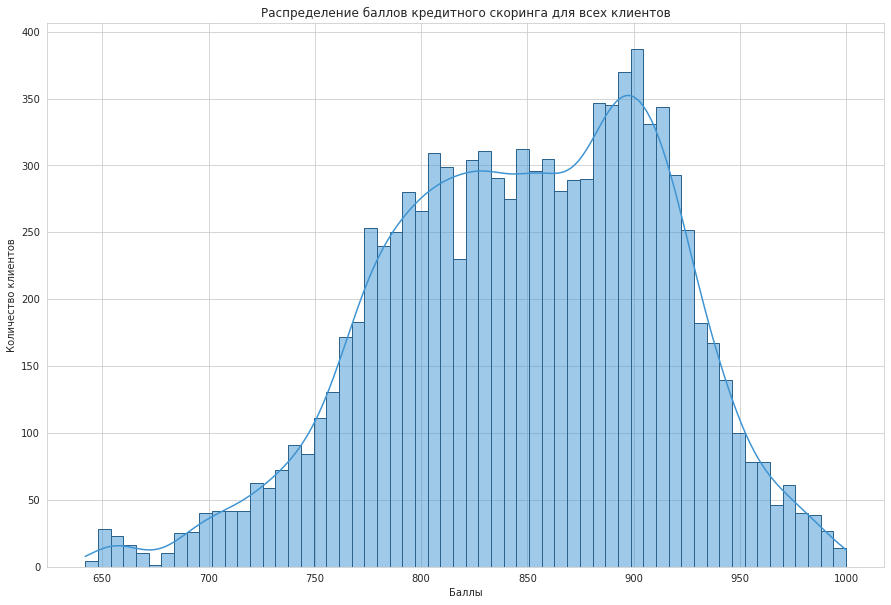

In [17]:
sns.set_style('whitegrid')

plt.figure(figsize=(15, 10))
sns.histplot(bank['score'], bins=60, kde=True, color='#3f94d3', edgecolor='#2b638d')
plt.title('Распределение баллов кредитного скоринга для всех клиентов')
plt.xlabel('Баллы')
plt.ylabel('Количество клиентов')
plt.show()

In [18]:
bank['score'].mean()

848.6918075422627

Наибольшее количество клиентов имеют `от 875 до 915` баллов кредитного скоринга, а среднее количество баллов у клиента равно `848` баллам. Распределение имеет плавный набор количества человек ближе к середине и резкое падение к своему окончанию.

Меньше всего клиентов с менее 650 баллами и 675 баллами.

#### Соотношение пола клиентов

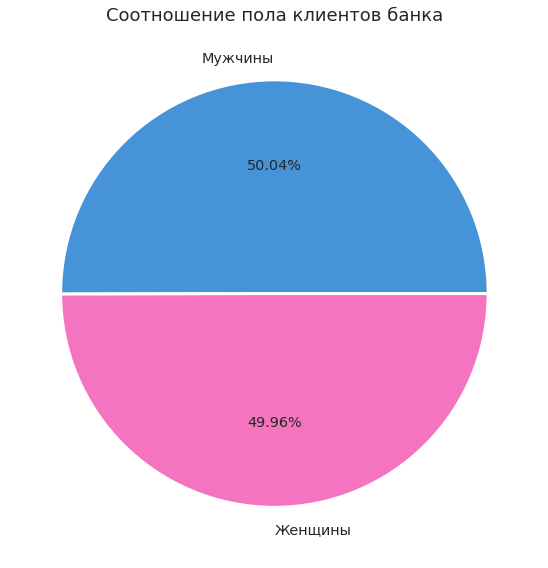

In [19]:
# Группируем пол клиента по количеству клиентов
hist_gender_for_all = (
    bank
    .groupby('gender')
    .agg({'user_id':'nunique'})
    .rename(columns={'user_id':'users_count'})
    .sort_values(by='users_count', ascending=False)
    .reset_index()
)
#hist_gender_for_all
# Задаем подписи сегментов круговой диаграммы
pc_labels = ['Мужчины', 'Женщины']
# Задаем размер графика
fig, ax = plt.subplots(figsize=(8, 8))
# Задаем цветовую гамму графика
colors = ['#4793d8', '#f574c0']
# Задаем основные параметры круговой диаграммы
ax.pie(hist_gender_for_all['users_count'], labels=pc_labels, autopct='%.2f%%',
       wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'},
       colors = colors)
ax.set_title('Соотношение пола клиентов банка', fontsize=18)
plt.tight_layout()

Как видно из графика, клиентов-мужчин в банке больше всего на 7 *(0,04 %)* человек, что, по сути, не является большой разницей и точный пол клиента банка определить нельзя.

#### Распределение возраста клиентов

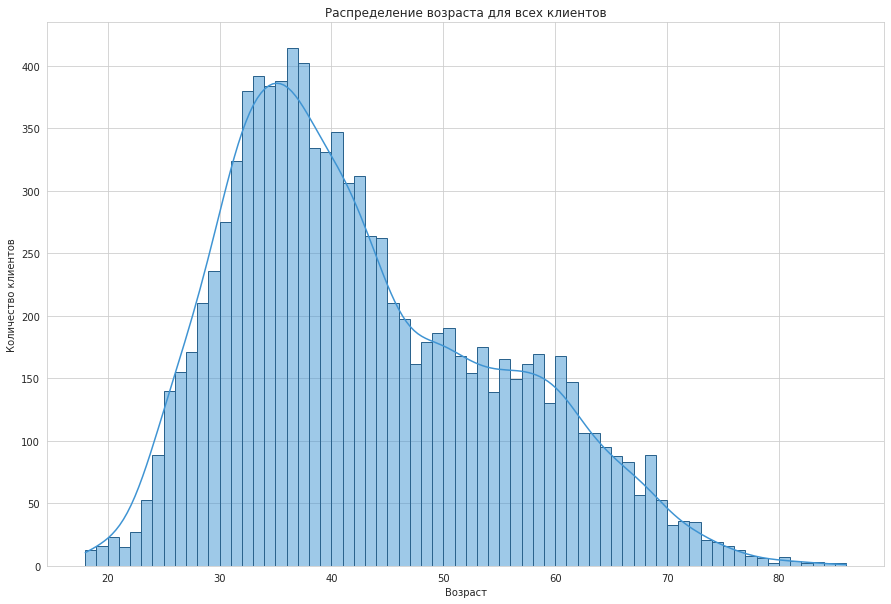

In [20]:
plt.figure(figsize=(15, 10))
sns.histplot(bank['age'], binwidth=1, kde=True, color='#3f94d3', edgecolor='#2b638d')
plt.title('Распределение возраста для всех клиентов')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()

In [21]:
bank['age'].mean()

42.72811843553066

Большинство клиентов банка это люди от 31 до 38 лет. При этом, график распределения резко растёт в начале и плавно сходит "на нет" к концу. Если брать конкретный возраст, по распределению видно, что наибольшая категория клиентов находится в возрасте примерно 33 лет. Средний возраст клиента банка равен 42 годам.

#### Распределение баллов собственности

In [22]:
# Группируем количество баллов собственности по количеству клиентов
hist_equity_for_all = (
    bank
    .groupby('equity')
    .agg({'user_id':'nunique'})
    .reset_index()
    .sort_values(by='user_id', ascending=False)
)
# Считаем медианное количество клиентов в категориях
hist_equity_for_all['user_id'].median()

912.0

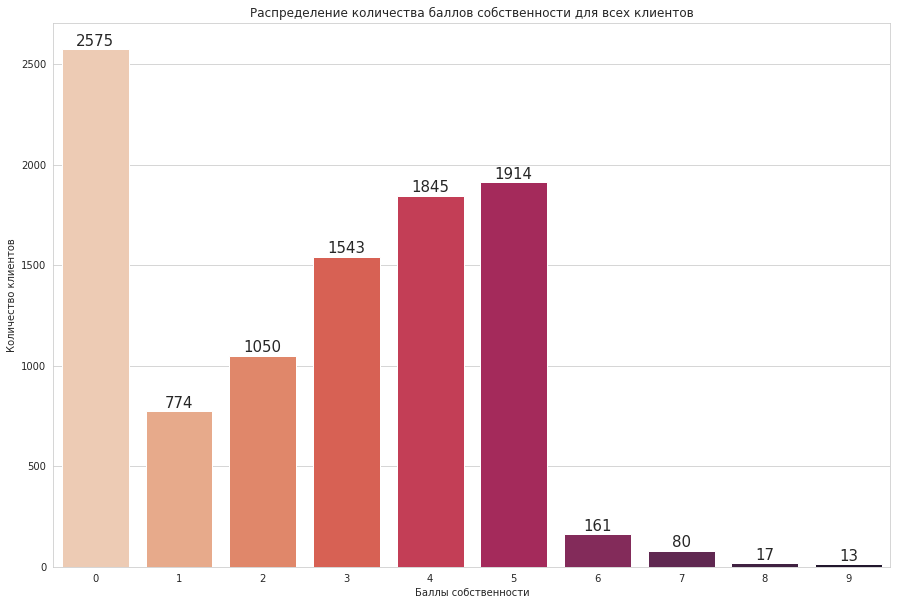

In [23]:
# Задаем размер графика
plt.figure(figsize=(15, 10))
# Задаем параметры графика
ax = sns.barplot(data=hist_equity_for_all, x='equity', y='user_id', palette='rocket_r')
# Прикрепляем количество клиентов к каждой категории
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
# Задаём подписи к графику
plt.title('Распределение количества баллов собственности для всех клиентов')
plt.xlabel('Баллы собственности')
plt.ylabel('Количество клиентов')
plt.show()

In [24]:
bank['equity'].median()

3.0

Из графика выше мы можем сделать вывод что наибольшая категория клиентов имеет `0` баллов собственности. Медиана говорит нам о том, что баллов собственности у клиентов, обычно, 3.

#### Распределение текущего баланса

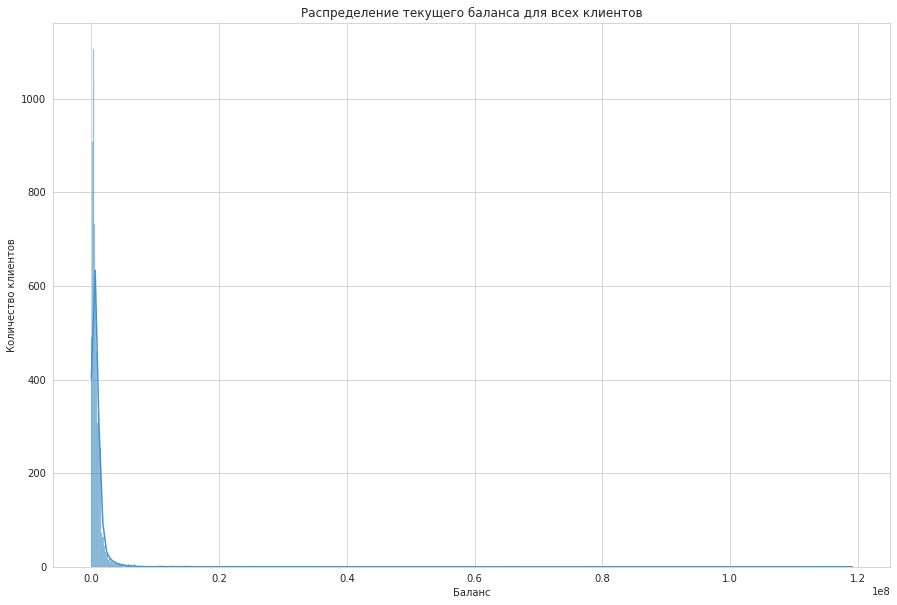

In [25]:
plt.figure(figsize=(15, 10))
sns.histplot(bank['balance'], bins=1000, kde=True, color='#3f94d3', edgecolor='#2b638d')
plt.title('Распределение текущего баланса для всех клиентов')
plt.xlabel('Баланс')
plt.ylabel('Количество клиентов')
plt.show()

Из такого графика распределения вывод не сделать - увеличим размер корзин и ограничим ось абсцисс.

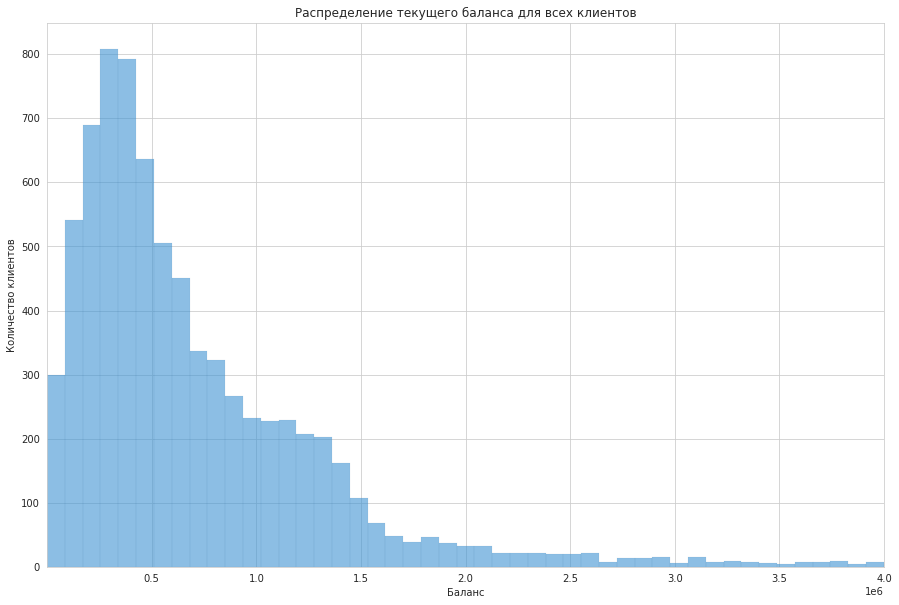

In [26]:
plt.figure(figsize=(15, 10))
sns.histplot(bank['balance'], bins=1400, alpha=0.6, color='#3f94d3', edgecolor='#2b638d')
plt.xlim(1, 4000000)
plt.title('Распределение текущего баланса для всех клиентов')
plt.xlabel('Баланс')
plt.ylabel('Количество клиентов')
plt.show()

In [27]:
bank['balance'].median()

524225.135

`Ось абсцисс 10 в степени 6`

Из графика видно, что наибольшее количество клиентов банка имеют текущий баланс до 500 тысяч, медиана указывает также на 524 тысячи.

#### Распределение количества продуктов, используемых клиентом

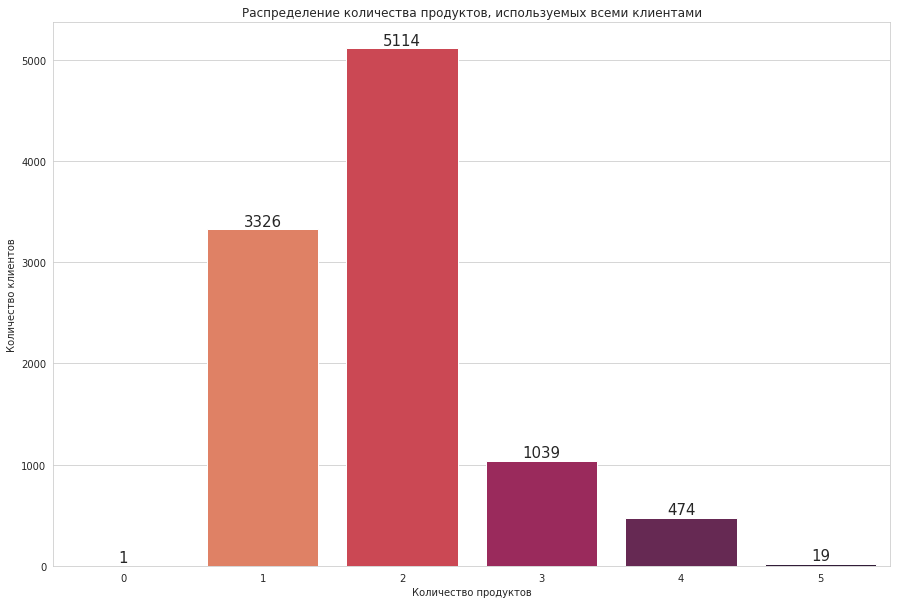

In [28]:
# Группируем количество продуктов по количеству клиентов
hist_product_for_all = (
    bank
    .groupby('products')
    .agg({'user_id':'nunique'})
    .reset_index()
    .sort_values(by='user_id', ascending=False)
)
# Задаем размер графика
plt.figure(figsize=(15, 10))

ax = sns.barplot(data=hist_product_for_all, x='products', y='user_id', palette='rocket_r')

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.title('Распределение количества продуктов, используемых всеми клиентами')
plt.xlabel('Количество продуктов')
plt.ylabel('Количество клиентов')
plt.show()

Клиент банка, не пользующийся ни одним продуктом банка? Странно. Что это за клиент?

Наибольшая категория клиентов - `5114` пользуется только 2 продуктами банка, следом за ней категория клиентов, пользующаяся одним продуктом. Далее, чем больше продуктов у клиента, тем меньше эта категория клиентов.

In [29]:
bank[bank['products']==0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,nan_balance,nan_age,gender_one_hot_Ж,gender_one_hot_М,city_one_hot_Ростов,city_one_hot_Рыбинск,city_one_hot_Ярославль
8957,147837,962,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,1,0,1,0,0,1,0


Клиент с высоким уровнем кредитного скоринга, о балансе которого ничего не известно, но уровень зарплаты равен 25 тысячам. 

Стоит избавить наши данные от подобного вброса.

In [30]:
bank = bank.query('products > 0')

#### Распределение оценочного дохода клиента

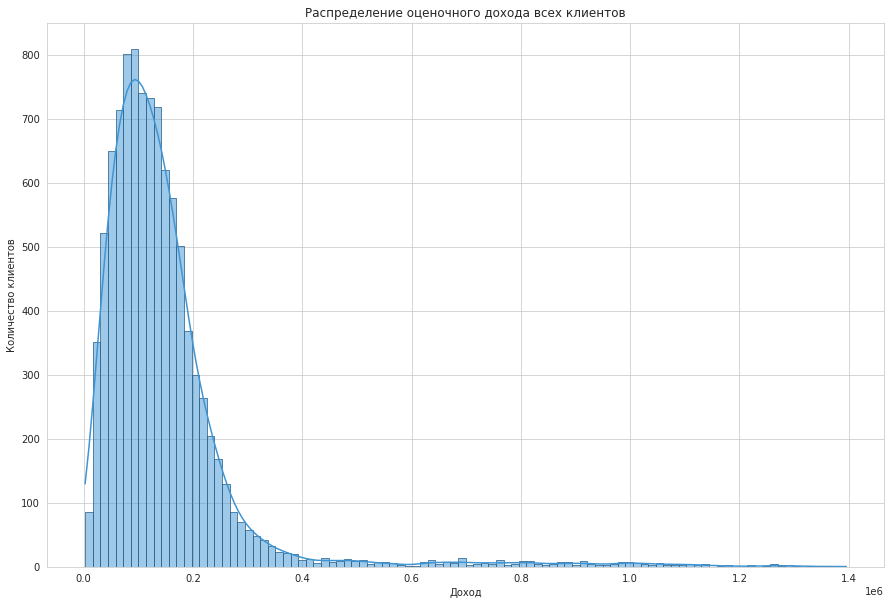

In [31]:
plt.figure(figsize=(15, 10))
sns.histplot(bank['est_salary'], bins=100, kde=True, color='#3f94d3', edgecolor='#2b638d')
plt.title('Распределение оценочного дохода всех клиентов')
plt.xlabel('Доход')
plt.ylabel('Количество клиентов')
plt.show()

По данному графику можно определить, что основная категория клиентов имеет доход до 300 тысяч. Опять же, изменим количество корзин и ограничим график по оси абсцисс чтобы посмотреть на основную категорию клиентов точнее.

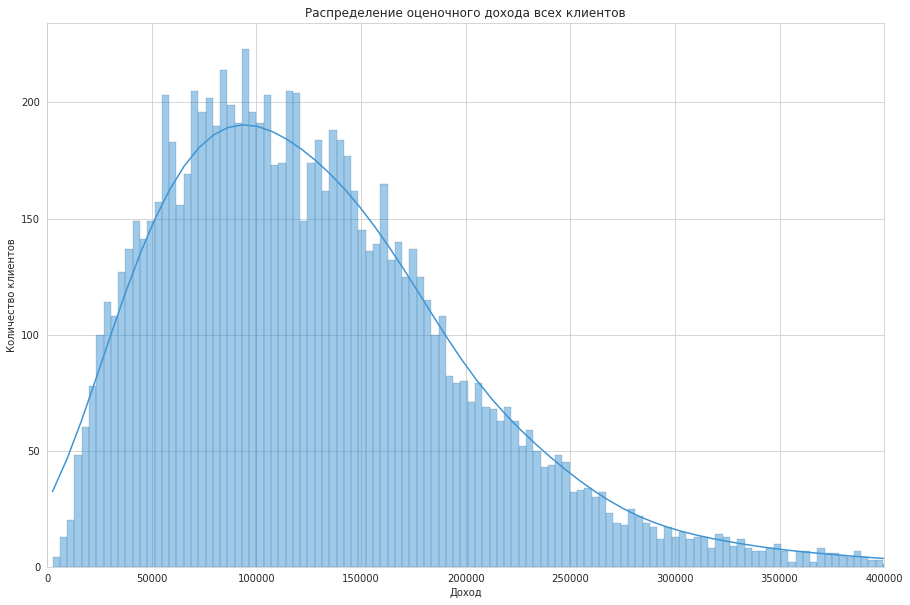

In [32]:
plt.figure(figsize=(15, 10))
sns.histplot(bank['est_salary'], bins=400, kde=True, color='#3f94d3', edgecolor='#2b638d')
plt.xlim(0, 400000)
plt.title('Распределение оценочного дохода всех клиентов')
plt.xlabel('Доход')
plt.ylabel('Количество клиентов')
plt.show()

Данный график вполне нормально распределен, основная категория клиентов имеет доход `90000`.

#### Промежуточный вывод

Теперь мы можем составить примерный портрет пользователей банка, основываясь на основных категориях:

1) Наибольшее количество клиентов имеют `от 875 до 910` баллов кредитного скоринга;

2) Мужчин и женщин клиентов банка в данных `одинаковое количество`;

3) Большинство клиентов банка это люди `от 31 до 38 лет`;

4) Основная категория клиентов имеет `0 баллов собственности`;

5) Наибольшее количество клиентов банка имеют текущий баланс до `500 тысяч`;

6) Самая большая категория клиентов - 5114 пользуется только `2 продуктами банка`;

7) Основная категория клиентов имеет доход `90000`.

Теперь посмотрим на распределение признаков в разрезе оттока клиентов.

### Распределение признаков отточных пользователей

#### Поиск отточных интервалов

В данном подпункте мы будем рассматривать непрерывные признаки отточных клиентов. Суть состоит в нахождении интервалов, наиболее склонных к оттоку. 

Для начала, создадим переменную, куда внесём только отточных клиентов. 

In [33]:
churn_clients = bank.query('churn == 1')
len(churn_clients)

1819

Количество отточных клиентов не изменилось в сравнении с изначальными данными, значит, мы всё сделали правильно. Перейдём к анализу.

##### Распределение баллов крединого скоринга

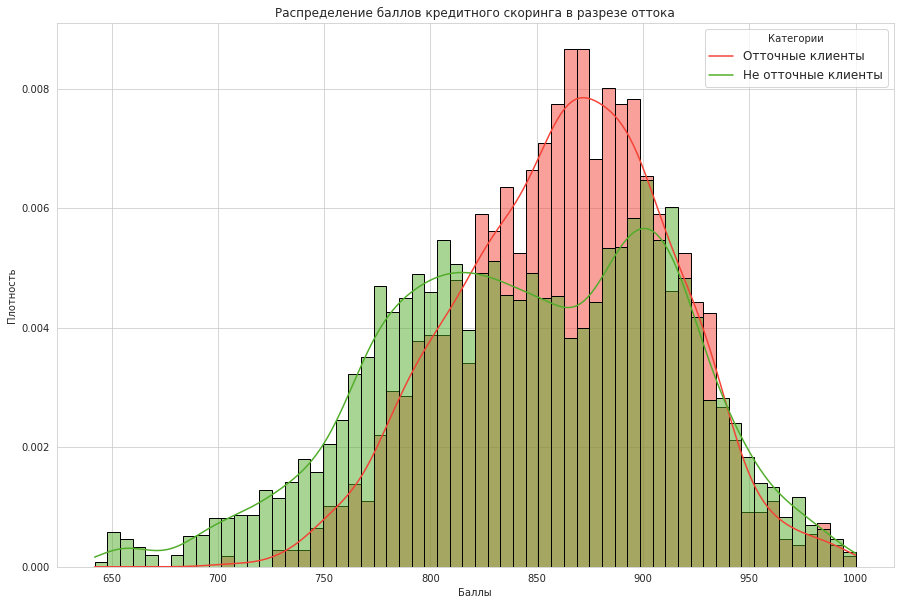

In [34]:
plt.figure(figsize=(15, 10))
color = ['#52ad2b', '#f44336']

sns.histplot(
    data=bank, x='score', hue='churn', bins=60, stat="density", common_norm=False, kde=True, alpha=0.5, palette=color, edgecolor='black'
)

legend_label = ['Отточные клиенты', 'Не отточные клиенты']
plt.legend(title='Категории', labels=legend_label, loc='upper right', fontsize=12)
plt.title('Распределение баллов кредитного скоринга в разрезе оттока')
plt.xlabel('Баллы')
plt.ylabel('Плотность')
plt.show()

Наибольшая категория отточных клиентов находится в интервале `от 860 до 900` баллов кредитного скоринга и график плотности близок к нормальному, в то время как у не отточных клиентов имеется два интервала - `от 775 до 860` и `от 875 и до 920`.

##### Распределение возраста

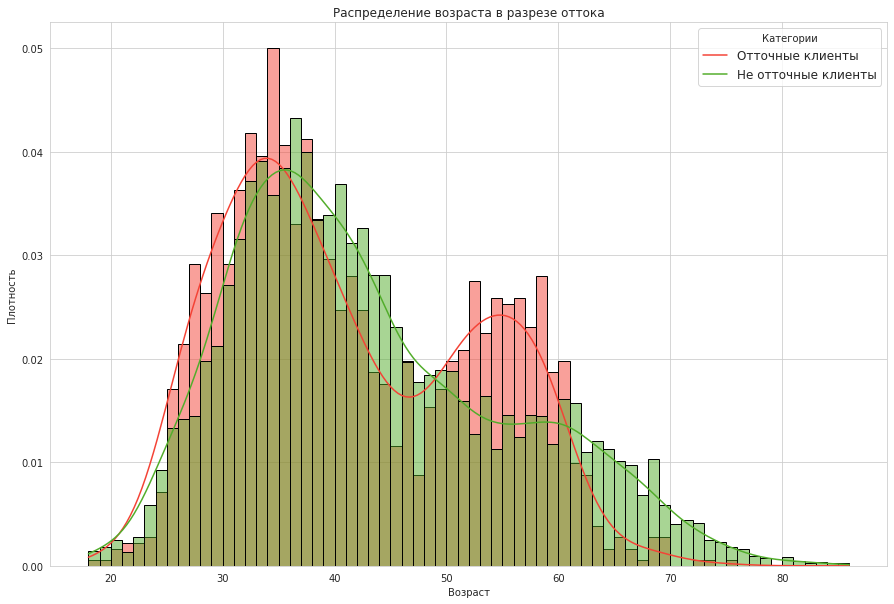

In [35]:
plt.figure(figsize=(15, 10))

sns.histplot(
    data=bank, x='age', hue='churn', binwidth=1, stat="density", common_norm=False, kde=True, alpha=0.5, palette=color, edgecolor='black'
)

legend_label = ['Отточные клиенты', 'Не отточные клиенты']
plt.legend(title='Категории', labels=legend_label, loc='upper right', fontsize=12)
plt.title('Распределение возраста в разрезе оттока')
plt.xlabel('Возраст')
plt.ylabel('Плотность')
plt.show()

Здесь мы можем выделить сразу две категории отточных клиентов: возрастом `от 28 до 41` и `от 52 и до 59` лет. 

У не отточных клиентов ситуация похожа, первый интервал находится в пределах `30 и 43` лет, но правая половина графика более плавная к спуску, небольшой *взлёт* наблюдается `от 58 до 61`.

##### Распределение текущего баланса

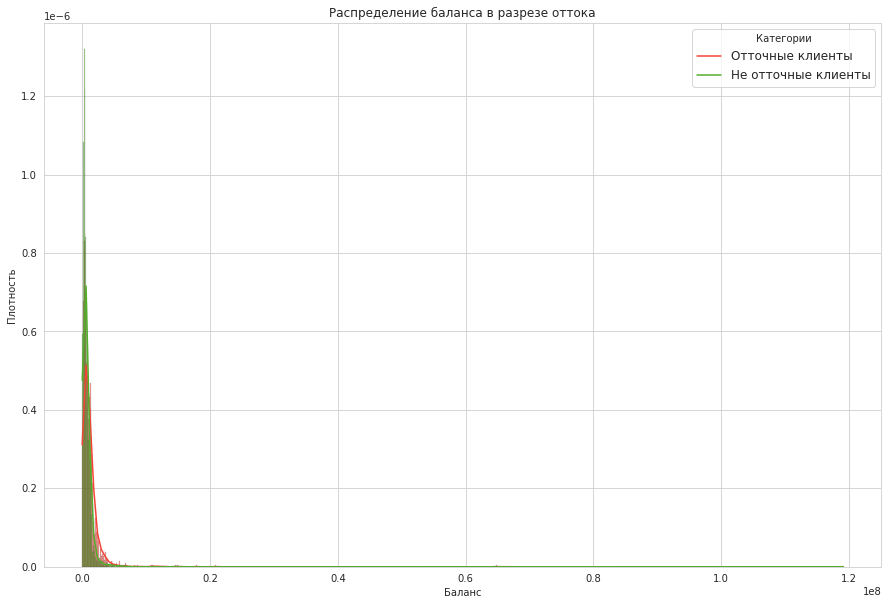

In [36]:
plt.figure(figsize=(15, 10))

sns.histplot(
    data=bank, x='balance', hue='churn', bins=1000, stat="density", common_norm=False, kde=True, alpha=0.5, palette=color, edgecolor='black'
)

legend_label = ['Отточные клиенты', 'Не отточные клиенты']
plt.legend(title='Категории', labels=legend_label, loc='upper right', fontsize=12)
plt.title('Распределение баланса в разрезе оттока')
plt.xlabel('Баланс')
plt.ylabel('Плотность')
plt.show()

Снова на графике распределения ничего не понятно, настроим масштаб.

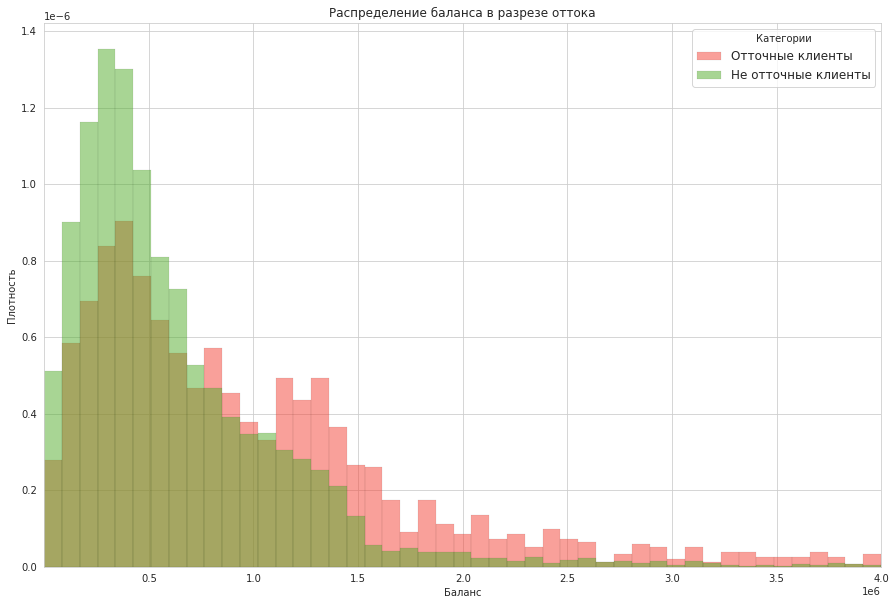

In [37]:
plt.figure(figsize=(15, 10))

sns.histplot(
    data=bank, x='balance', hue='churn', bins=1400, stat="density", common_norm=False, alpha=0.5, palette=color, edgecolor='black'
)

legend_label = ['Отточные клиенты', 'Не отточные клиенты']
plt.legend(title='Категории', labels=legend_label, loc='upper right', fontsize=12)
plt.xlim(1, 4000000)
plt.title('Распределение баланса в разрезе оттока')
plt.xlabel('Баланс')
plt.ylabel('Плотность')
plt.show()

У отточных клиентов график более плавный во второй половине (то есть дисперсия выборки более высокая), количество клиентов с баллансом `более миллиона` выше, чем у не отточных.

Основной интервал текущего баланса отточных клиентов находится в пределах `от 250 тысяч до 500 тысяч`.
У не отточных клиентов диапазон чуть шире - `от 150 тысяч до 600 тысяч`.

##### Распределение оценочного дохода клиента

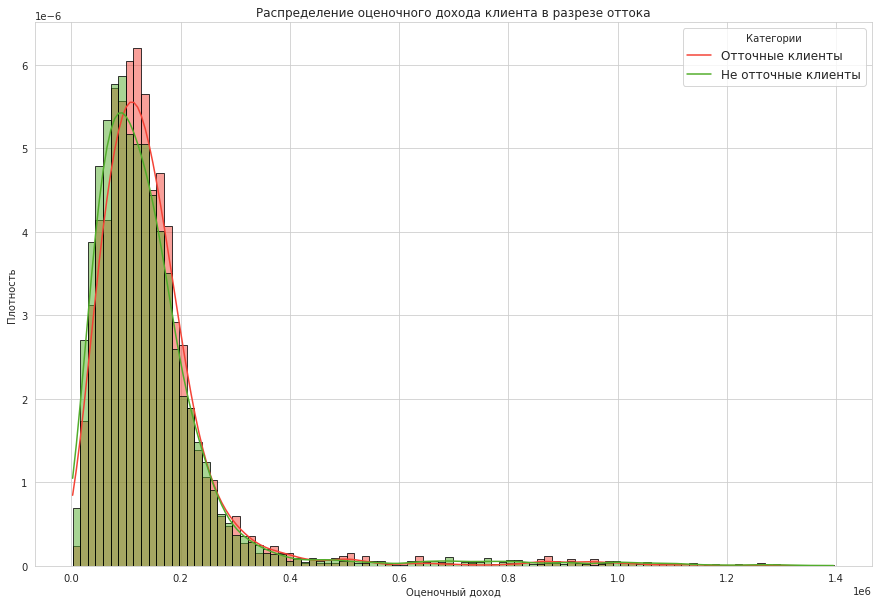

In [38]:
plt.figure(figsize=(15, 10))

sns.histplot(
    data=bank, x='est_salary', hue='churn', bins=100, stat="density", common_norm=False, kde=True, alpha=0.5, palette=color, edgecolor='black'
)

legend_label = ['Отточные клиенты', 'Не отточные клиенты']
plt.legend(title='Категории', labels=legend_label, loc='upper right', fontsize=12)

plt.title('Распределение оценочного дохода клиента в разрезе оттока')
plt.xlabel('Оценочный доход')
plt.ylabel('Плотность')
plt.show()

Масштабируем график.

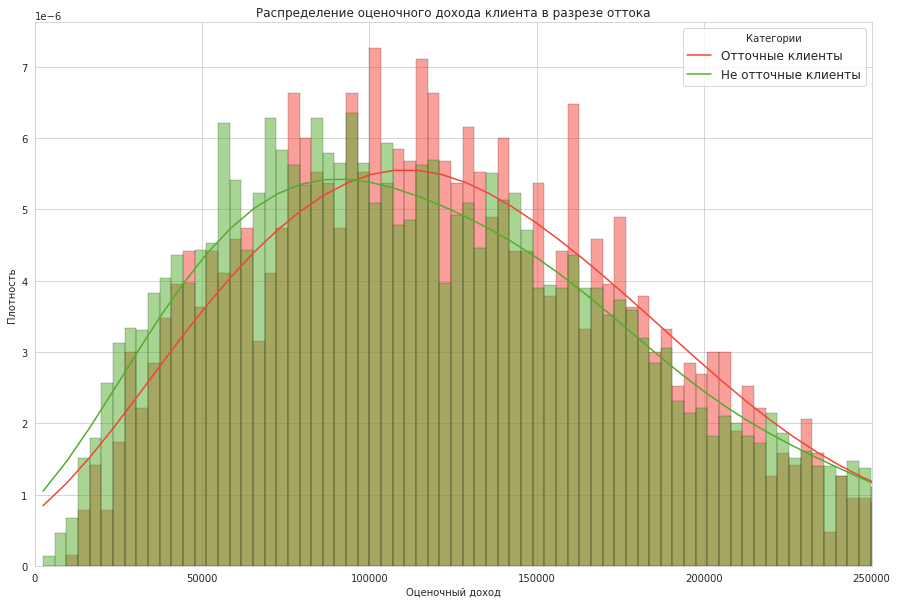

In [39]:
plt.figure(figsize=(15, 10))

sns.histplot(
    data=bank, x='est_salary', hue='churn', bins=400, stat="density", common_norm=False, kde=True, alpha=0.5, palette=color, edgecolor='black'
)

legend_label = ['Отточные клиенты', 'Не отточные клиенты']
plt.legend(title='Категории', labels=legend_label, loc='upper right', fontsize=12)
plt.xlim(0, 250000)
plt.title('Распределение оценочного дохода клиента в разрезе оттока')
plt.xlabel('Оценочный доход')
plt.ylabel('Плотность')
plt.show()

Графики очень близки друг к другу. 

Отточные клиенты, в своей массе, имеют оценочный доход `от 90 тысяч до 125 тысяч`.

Не отточные клиенты имеют оценочный доход `от 65 тысяч до 100 тысяч`.

Теперь перейдём к дискретным признакам отточных и не отточных клиентов.

#### Поиск отточных категорий

##### Определение города

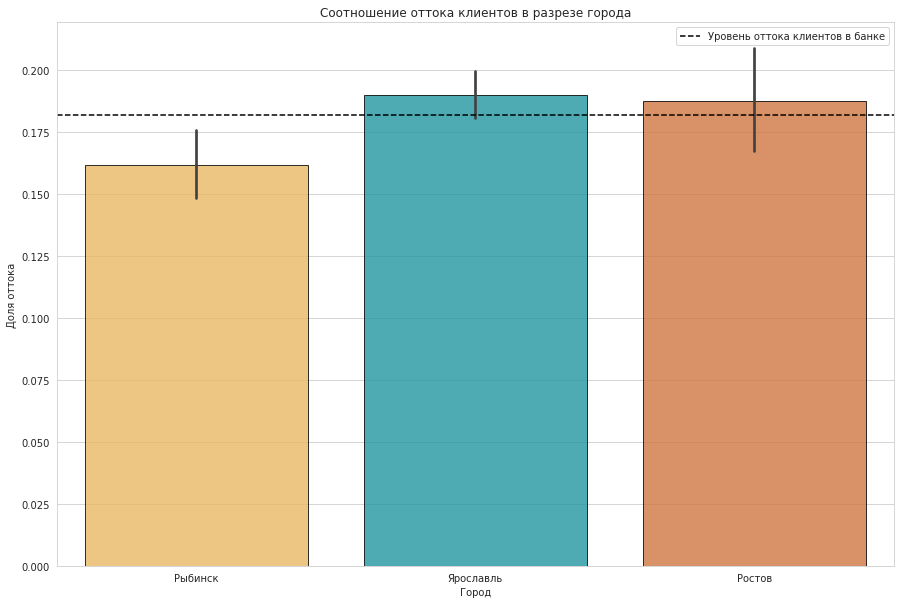

In [40]:
plt.figure(figsize=(15, 10))

ax = sns.barplot(
    data=bank, x='city', y='churn', alpha=0.8, palette=['#ffbe4f', '#0ea7b5', '#e8702a'], edgecolor='black'
)
plt.axhline(y=0.182, color='black', linestyle='--', label='Уровень оттока клиентов в банке')

plt.title('Cоотношение оттока клиентов в разрезе города')
plt.legend()
plt.xlabel('Город')
plt.ylabel('Доля оттока')
plt.show()

Самые не отточные клиенты из Рыбинска, а самые отточные - из Ярославля. Уровень оттока Ростовских клиентов также выше среднего по банку.

##### Определение пола

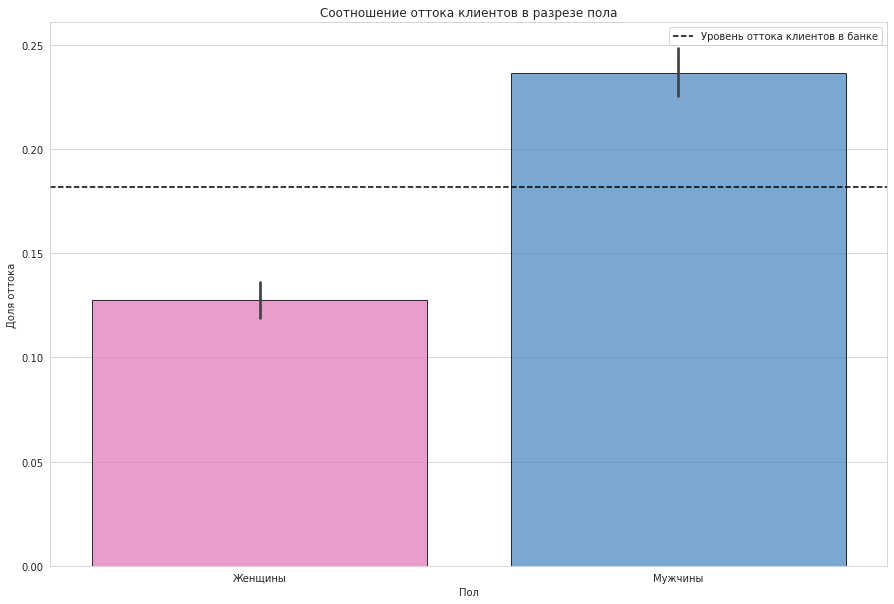

In [41]:
plt.figure(figsize=(15, 10))

ax = sns.barplot(
    data=bank, x='gender', y='churn', alpha=0.8, palette=['#f574c0', '#4793d8'], edgecolor='black'
)
plt.axhline(y=0.182, color='black', linestyle='--', label='Уровень оттока клиентов в банке')

ax.set_xticklabels(['Женщины', 'Мужчины'])

plt.title('Cоотношение оттока клиентов в разрезе пола')
plt.legend()
plt.xlabel('Пол')
plt.ylabel('Доля оттока')
plt.show()

Как видно из столбчатой диаграммы, клиенты-мужчины более склонны к оттоку, нежели клиенты-женщины. Средний уровень оттока в банке составляет `18.2 %`, клиенты-мужчины выше этого уровня примерно на `5 %`, в то время как клиенты-женщины меньше на `5 %`.

##### Распределение баллов собственности

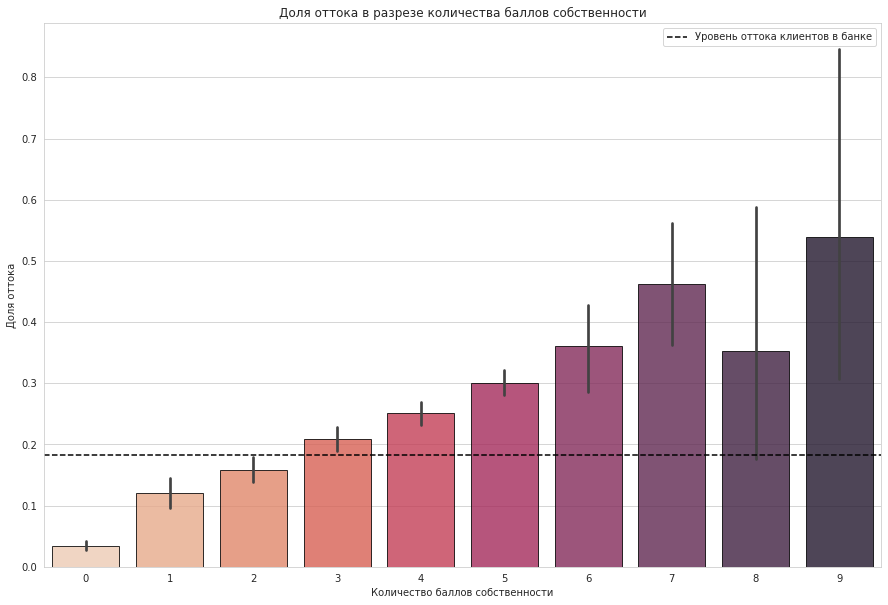

In [42]:
plt.figure(figsize=(15, 10))

ax = sns.barplot(
    data=bank, x='equity', y='churn', alpha=0.8, palette='rocket_r', edgecolor='black'
)
plt.axhline(y=0.182, color='black', linestyle='--', label='Уровень оттока клиентов в банке')

plt.title('Доля оттока в разрезе количества баллов собственности')
plt.legend()
plt.xlabel('Количество баллов собственности')
plt.ylabel('Доля оттока')
plt.show()

Наиболее многочисленная группа клиентов, имеющая 0 баллов собственности, наименее склонна к оттоку. Начиная с 3х баллов собственности уровень оттока клиентов выше, чем уровень по всем данным. 

В целом, из графика видно, чем больше у клиента баллов собственности, тем более он склонен к оттоку, исключение составляет лишь группа клиентов, имеющая 8 баллов собственности.

Наиболее склонна к оттоку группа клиентов, имеющая 9 баллов собственности. Следом за ней идет группа клиентов с 7 баллами собственности и замыкает тройку группа клиентов с 6 баллами собственности. Однако, все эти группы состоят из слишком малого количества клиентов, поэтому, лучше всего будет обратить внимание на клиентов с 3, 4 и 5 баллами собственностию

##### Распределение количества продуктов, используемых клиентом

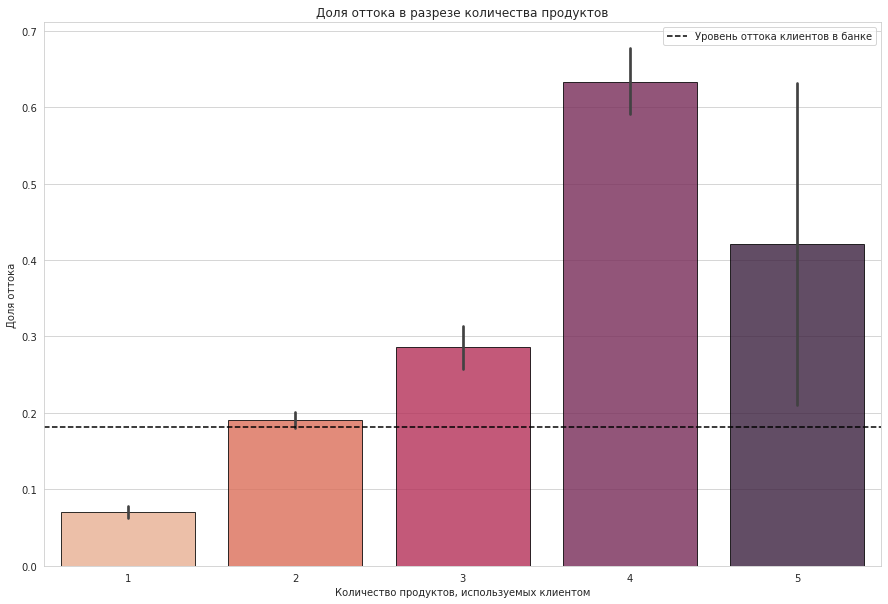

In [43]:
plt.figure(figsize=(15, 10))

ax = sns.barplot(
    data=bank, x='products', y='churn', alpha=0.8, palette='rocket_r', edgecolor='black'
)
plt.axhline(y=0.182, color='black', linestyle='--', label='Уровень оттока клиентов в банке')

plt.title('Доля оттока в разрезе количества продуктов')
plt.legend()
plt.xlabel('Количество продуктов, используемых клиентом')
plt.ylabel('Доля оттока')
plt.show()

Группа клиентов, пользующихся 5-ю продуктами банка не подлежит анализу ввиду слишком малого количества клиентов.

Наиболее многочислены группы клиентов, имеющих 1, 2 и 3 продукта. Из них, группа клиентов, пользующихся одним продуктом банка, наименее склонна к оттоку - `~ 10%`, что ниже общеклиентской на 8 %. У самой многочисленной группы клиентов, пользующихся двумя продуктами банка, доля отточных клиентов чуть выше общеклиентского. Доля клиентов, пользующихся 4 продуктами, наиболее склонная к оттоку.

##### Определение наличия кредитной карты

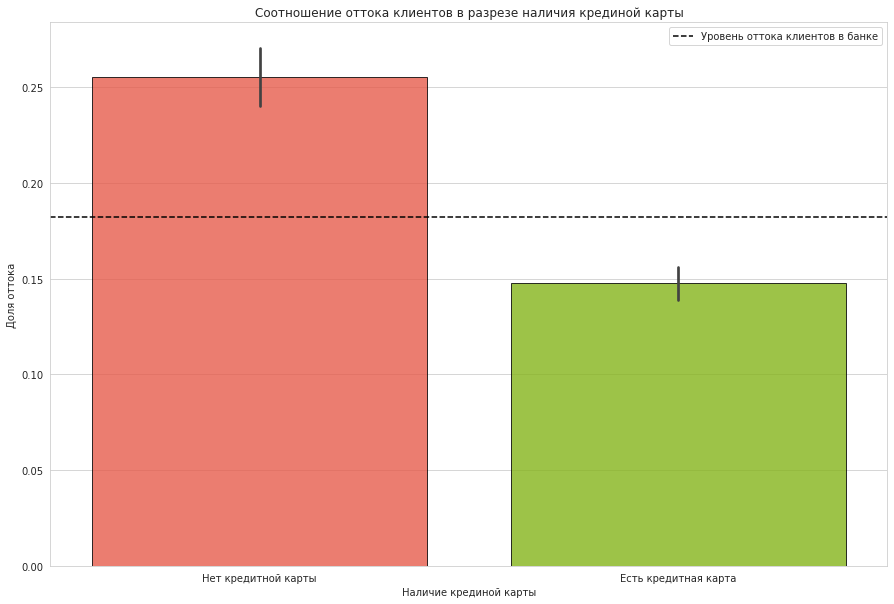

In [44]:
plt.figure(figsize=(15, 10))

ax = sns.barplot(
    data=bank, x='credit_card', y='churn', alpha=0.8, palette=['#ff4833', '#8fce00'], edgecolor='black'
)
plt.axhline(y=0.182, color='black', linestyle='--', label='Уровень оттока клиентов в банке')

ax.set_xticklabels(['Нет кредитной карты', 'Есть кредитная карта'])

plt.title('Cоотношение оттока клиентов в разрезе наличия крединой карты')
plt.legend()
plt.xlabel('Наличие крединой карты')
plt.ylabel('Доля оттока')
plt.show()

Наиболее склонны к оттоку клиенты, не пользующиеся кредитной картой банка, причем их отток выше общебанковского на 7 %.

##### Определение активности клиента

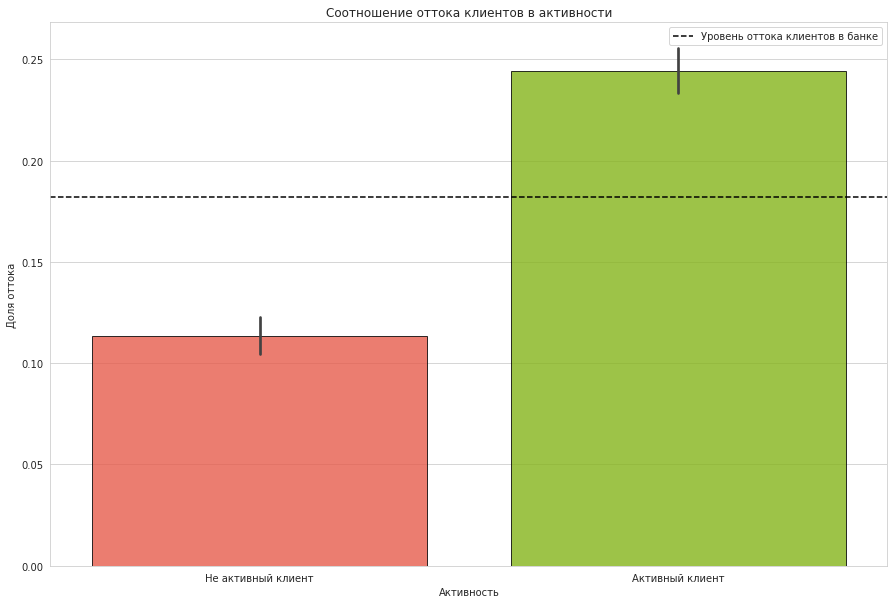

In [45]:
plt.figure(figsize=(15, 10))

ax = sns.barplot(
    data=bank, x='last_activity', y='churn', alpha=0.8, palette=['#ff4833', '#8fce00'], edgecolor='black'
)
plt.axhline(y=0.182, color='black', linestyle='--', label='Уровень оттока клиентов в банке')

ax.set_xticklabels(['Не активный клиент', 'Активный клиент'])

plt.title('Cоотношение оттока клиентов в активности')
plt.legend()
plt.xlabel('Активность')
plt.ylabel('Доля оттока')
plt.show()

Не активные клиенты менее склонны к оттоку, нежели клиенты, пользующиеся услугами банка на регулярной основе. Предполагаю, что людям проще забыть про продукты банка и дождаться окончания срока договора, чем завершать обслуживание. Доля отточных клиентов среди не активных - чуть более `10 %`, в то время как активных почти `25 %`.

В данном подпункте мы определяли наиболее отточные интервалы групп клиентов, а также, выбирали отточные категории. Пришло время составить портрет отточного и не отточного клиента.

### Определение портрета клиентов

#### Сравнение мер центральной тенденции в разрезе оттока

In [46]:
churn_grouped = (
    bank
    .groupby('churn')
    .agg({'score':'mean', 'est_salary':'mean', 'balance':'mean', 'age':'mean', 'equity':'median', 'products':'median', \
          'city':get_mode, 'gender':get_mode, 'credit_card':get_mode, 'last_activity':get_mode})
)
churn_grouped = churn_grouped.transpose()
churn_grouped = churn_grouped.rename(columns={0:'non-churn clients', 1:'churn clients'})
churn_grouped.index = ['mean_score', 'mean_salary', 'mean_balance', 'mean_age', 'median_equity', 'median_products', \
                       'mode_city', 'mode_gender', 'mode_credit_card', 'mode_activity']
churn_grouped['relative_diff'] = churn_grouped['churn clients'][0:4] / churn_grouped['non-churn clients'][0:4] * 100
churn_grouped = churn_grouped.fillna('not required')
churn_grouped

churn,non-churn clients,churn clients,relative_diff
mean_score,845.417879,863.346894,102.120728
mean_salary,147760.424387,148310.728202,100.37243
mean_balance,733971.944219,1133993.27145,154.500902
mean_age,43.012719,41.428807,96.317574
median_equity,3,4,not required
median_products,2,2,not required
mode_city,Ярославль,Ярославль,not required
mode_gender,Ж,М,not required
mode_credit_card,1,1,not required
mode_activity,0,1,not required


* Среднее количество баллов кредитного скоринга у отточных клиентов выше, чем у не отточных клиентов.

* Исходя из таблицы, у не отточных клиентов уровень зарплаты действительно чуть ниже, чем у отточных, но не такую разницу, о которой я писал в п.3.2.1.4. 

* Текущий баланс у отточных клиентов больше чем у не отточных на 54 %.

* Также, не отточный клиент старше на год типичного отточного клиента. 

* Он имеет 3 балла собственности, что на 1 меньше, чем у отточного. 

* Количество продуктов в обеих группах одинаково, как и город оформления. 

* Вывод о поле не отточного клиента правилен, чаще всего, это женщина, в то время как у отточного - мужчина.

* Мода по наличию кредитной карты у отточных и не отточных клиентов одинакова - кредитная карта есть.

* Как и было сказано выше, отточные клиенты чаще активные. Мода подтверждает это утверждение.

#### Портрет не отточного клиента

Здесь соберем всю информацию о неотточных клиентах:

1) *Кредитный скоринг*. У не отточных клиентов имеется два интервала с наибольшим числом клиентов - `от 775 до 860` и `от 875 и до 920` баллов кредитного скоринга;

2) *Возраст*. У не отточных клиентов первый интервал находится в пределах `30 и 43` лет, второй -  `от 58 до 61`, средний возраст равен 43.

3) *Текущий баланс*. Диапазон текущего баланса - `от 150 тысяч до 600 тысяч`.

4) *Оценочный доход*. Не отточные клиенты имеют оценочный доход `от 65 тысяч до 100 тысяч`, средний доход равен 147 тысячам.

5) *Пол*. Менее склонны к оттоку клиенты-женщины, уровень оттока меньше чем общебанковский на `5 %`.

6) *Город*. Наименее отточные клиенты оформлены в отделении банка в `Рыбинске`, хотя мода не отточных клиентов - `Ярославль`.

7) *Баллы собственности*. Наиболее многочисленная группа клиентов, имеющая 0 баллов собственности, наименее склонна к оттоку. Всего существует три группы клиентов, чей уровень оттока меньше общебанковского - `0, 1 и 2` балла собственности, медиана равна 3 баллам собственности

8) *Количество продуктов*. Группа клиентов, пользующихся одним продуктом банка, наименее склонна к оттоку - `~ 10%`, что ниже общеклиентской на 8 %, медиана равна 2 продуктам банка.

9) *Наличие кредитной карты*. Клиенты, имеющие кредитную карту, менее склонны к оттоку.

10) *Активность*. Не активные клиенты менее склонны к оттоку. Доля отточных клиентов среди не активных - чуть более `10 %`.

#### Портрет отточного клиента

Теперь об отточных клиентах:

1) *Кредитный скоринг*. Наибольшая категория отточных клиентов находится в интервале `от 860 до 900` баллов кредитного скоринга.

2) *Возраст*. Две категории отточных клиентов: возрастом `от 28 до 41` и `от 52 и до 59` лет, средний возраст составляет 41 год.

3) *Текущий баланс*. Основной интервал текущего баланса отточных клиентов находится в пределах `от 250 тысяч до 500 тысяч`.

4) *Оценочный доход*. Отточные клиенты, в своей массе, имеют оценочный доход `от 90 тысяч до 125 тысяч`, средний доход равен 148 тысячам.

5) *Пол*. Клиенты-мужчины более склонны к оттоку, нежели клиенты-женщины. Средний уровень оттока в банке составляет `18.2 %`, клиенты-мужчины выше этого уровня примерно на `5 %`, мода также указывает на клиентов-мужчин.

6) *Баллы собственности*. Лучше всего будет обратить внимание на клиентов с `3, 4 и 5` баллами собственности, при этом, медиана указывает, что наибольшее число отточных клиентов имеет 4 балла собственности.

7) *Город*. Наиболее отточные клиенты проживают в `Ярославле`, мода города также - Ярославль.

8) *Количество продуктов*.  Доля клиентов, пользующихся 4 продуктами, наиболее склонная к оттоку. Следом за ней группа клиентов с 3 продуктами, медиана показывает, что наибольшее число отточных клиентов пользуется 2 продуктами.

9) *Наличие кредитной карты*. Наиболее склонны к оттоку клиенты, не пользующиеся кредитной картой банка, причем их отток выше общебанковского на 7 %.

10) *Активность*. Активные клиенты более склонны к оттоку.

### Поиск взаимосвязи оттоком и категориями клиентов

Составим матрицу корреляции и посмотрим есть ли связь между оттоком и другими переменными.

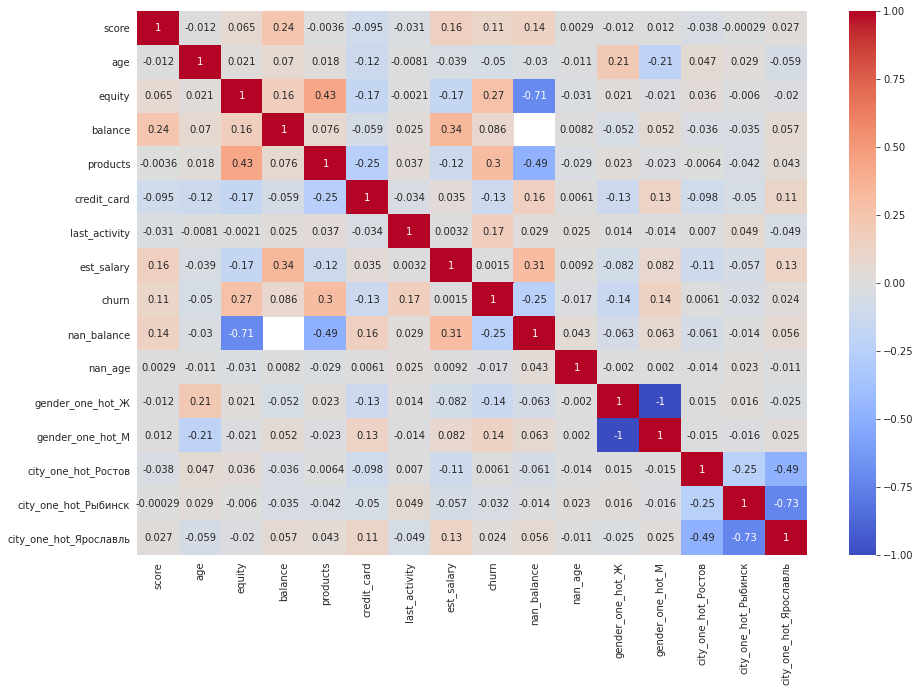

In [47]:
# Создаем переменную для корреляции и исключим столбец идентификатора для облегчения расчёта матрицы
bank_corr = bank.loc[:, ~bank.columns.isin(['user_id'])]

plt.figure(figsize=(15, 10))
ax = sns.heatmap(bank_corr.corr(), cmap='coolwarm', center=0, annot=True) 
plt.show()

Не совсем удобно искать корреляцию для столбца `churn` с другими столбцами, потому для него построим отдельную визуализацию. 

Из данного графика видно, что зависимости между столбцом `nan_age`, то есть, пропусками в столбце `age`, и остальными столбцами данных -  нет, соответственно, эти пропуски нужно расценивать как `отсутствующие совершенно случайно`. Мы можем как отбросить наши пропуски, так и заполнить, так как это никак не повлияет на характер связи между переменными. Пропусков у нас не более 30, влияния они никакого не оказывают, так что просто проигнорируем их.

Теперь о зависимости между `nan_balance`, то есть, пропусками в столбце `balance` с остальными столбцами:

* Высокая обратная зависимость между столбцом `nan_balance` и столбцом `equity`.

* Умеренную обратную зависимость между `nan_balance` и `products`.

* Умеренную прямую зависимость между `nan_balance` и `est_salary`.

* Слабую обратную зависимость между `nan_balance` и `churn`.

* Слабую прямую зависимость между `nan_balance` и столбцами `score` и `credit_card`.

Исходя из перечисленного выше, можем сделать вывод, что значения в столбце `balance` `отсутствуют не случайно`, и как заполнять их, так и отбрасывать их - нельзя, тем более, что это более чем 2500 строк, что составляет почти 25% данных.

Построим отдельную визуализацию корреляции столбца `churn` с остальными столбцами:

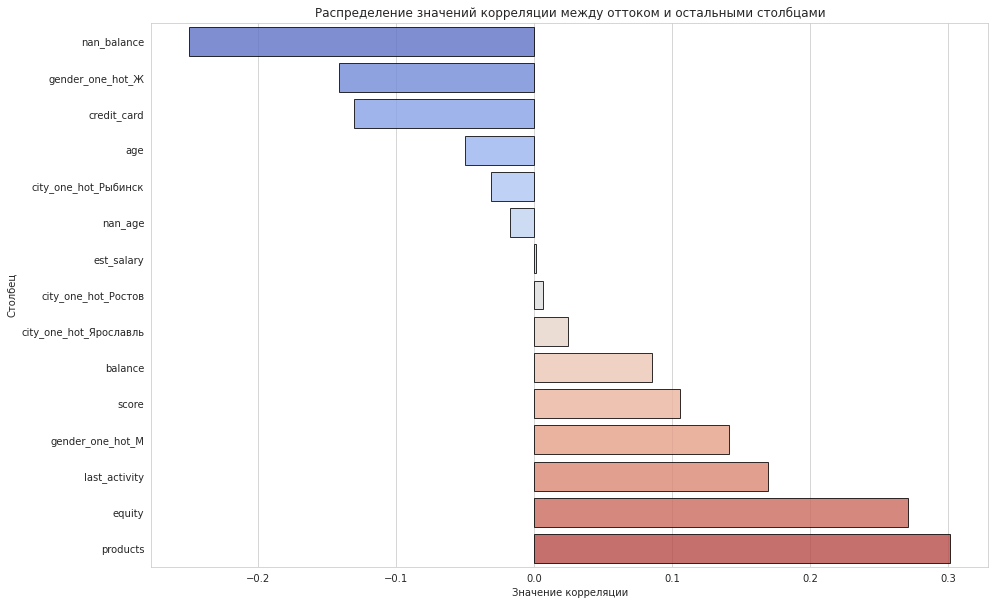

In [48]:
churn_corr = bank_corr.corr()['churn']
churn_corr = (
    churn_corr
    .sort_values()
    .reset_index()
    .rename(columns={'index':'sign', 'churn':'churn_value'})
    .drop([15])
)
plt.figure(figsize=(15, 10))

ax = sns.barplot(
    data=churn_corr, x='churn_value', y='sign', alpha=0.8, palette='coolwarm', edgecolor='black'
)

plt.title('Распределение значений корреляции между оттоком и остальными столбцами')
plt.xlabel('Значение корреляции')
plt.ylabel('Столбец')
plt.show()

Пользуюясь шкалой Чеддока, можем сделать вывод, что:

1) Значения корреляции от 0.1 и до -0.1 не считаются как существующая зависимость, поэтому, между `churn` и столбцами `age, nan_age, city, balance, est_salary` зависимости нет.

2) Между значением оттока `churn` и столбцами баллов кредитного скоринга `score`, активности клиента `last_activity`, мужского пола `gender_one_hot_М` и баллов собственности `equity` существует слабая прямая зависимость. Это означает, что зависимость есть, но она не так велика и делать вывод о существенном влиянии одного значения на другое - нельзя, однако, будем иметь это ввиду во время дальнейшей работы.

3) Обратную слабую зависимость между значением оттока `churn` и наличием кредитной карты `credit_card`, пропусками `nan_balance` и женским полом `gender_one_hot_Ж`.

4) Между значением оттока `churn` и количеством продуктов `products` существует умеренная прямая зависимость. В данном случае, зависимость выше, чем между предыдущим столбцами, однако значительного влияния данная зависимость, всё же, не оказывает.

## Проверка статистических гипотез

В данном пункте будем проверять статистические гипотезы. Но до начала проверки нужно определиться с выбором инструмента проверки. Например, `t-test` или `тест Стьюдента`. Условия его использования:

1) `Генеральные совокупности не зависят друг от друга.` В нашем случае, мы будем иметь две выборки с отточными или не отточными клиентами, которые действительно не зависят друг от друга.

2) `Выборочные средние нормально распределены.` Опять же, в нашем случае мы имеем ~8200 значений в одной выборке, и ~1800 в другой выборке, так что и оснований полагать, что случайно выбранные средние не будут распределены нормально - нет. 

3) `Дисперсии рассматриваемых генеральных совокупностей равны.` Мы имеем дело с двумя выборками, количество значений в которых имеет разницу более чем в 4 раза, так и что и оснований полагать, что дисперсии равные - нет. Однако, в условиях `t-теста` есть значение `equal var`, которое мы можем назначить как `False` и спокойно выполнить наши статистические тесты. При этом если выборки достаточно велики (30 и больше значений) и равны по размеру между собой, то такой подход оправдан. Симуляции, проведённые учёными, показывают, что даже если дисперсии на самом деле не равны, то тест редко ошибается.

Создадим отдельную переменную, в которой оставим только не отточных клиентов.

In [49]:
non_churn_clients = bank.query('churn == 0')
len(non_churn_clients)

8177

### Различие дохода между не отточными и отточными клиентами

Для чистоты эксперимента, проанализируем наши выборки на предмет вбросов и аномалий в интересующих нас столбцах.

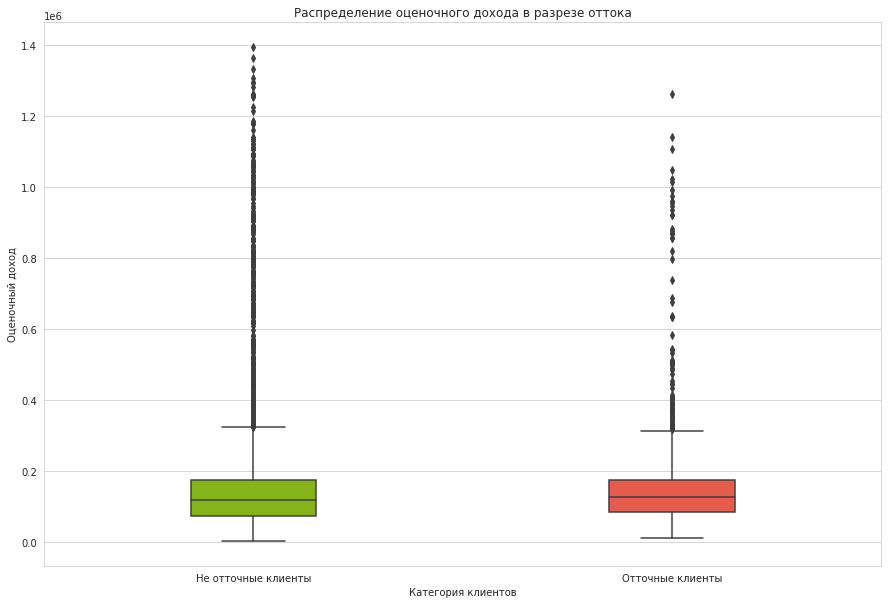

In [50]:
plt.figure(figsize=(15, 10))

ax = sns.boxplot(x='churn', y='est_salary', data=bank, palette=['#8fce00', '#ff4833'], width=0.3)

plt.title('Распределение оценочного дохода в разрезе оттока')
ax.set_xticklabels(['Не отточные клиенты', 'Отточные клиенты'])
plt.xlabel('Категория клиентов')
plt.ylabel('Оценочный доход')
plt.show()

Видно, что верхний порог оценочного уровня дохода у обеих категорий примерно на 350 тысячах. Масштабируем графики.

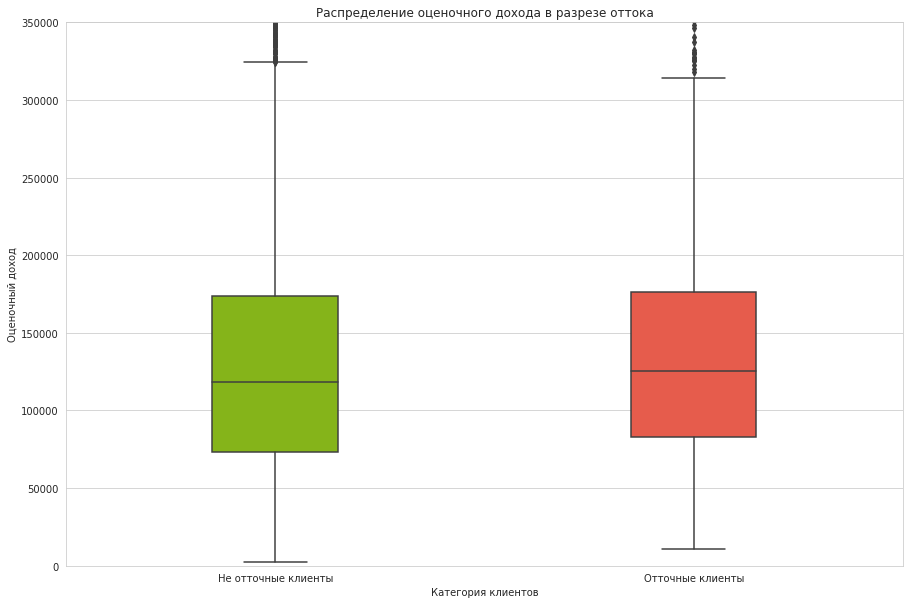

In [51]:
plt.figure(figsize=(15, 10))

ax = sns.boxplot(x='churn', y='est_salary', data=bank, palette=['#8fce00', '#ff4833'], width=0.3)

plt.title('Распределение оценочного дохода в разрезе оттока')
plt.xlabel('Категория клиентов')
plt.ylabel('Оценочный доход')
ax.set_xticklabels(['Не отточные клиенты', 'Отточные клиенты'])
plt.ylim(0, 350000)
plt.show()

Медианный уровень оценочного дохода у не отточных клиентов ниже, чем у отточных, хотя верхний порог зарплат у них выше.
Теперь избавим наши переменные для теста от вбросов.

In [52]:
churn_clients = churn_clients.query('est_salary < 315000')
non_churn_clients = non_churn_clients.query('est_salary < 325000')

Данные готовы к тесту.

Сформулируем нулевую и альтернативную гипотезы:

h0: *Не отточные клиенты зарабатывают столько же, сколько и отточные клиенты.*

h1: *Не отточные клиенты зарабатывают больше, чем отточные клиенты.*

Установим уровень статистической значимости равный 5 %.

In [53]:
# Записываем в переменные списки значений из столбцов
non_churn_salary = non_churn_clients['est_salary']
churn_salary = churn_clients['est_salary']
# Устанавливаем уровень статистической значимости
alpha = 0.05
# Задаем условия выполнения t-теста
results = st.ttest_ind(non_churn_salary, churn_salary, equal_var=False, alternative='greater')
# Выводим результат
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

p-значение: 0.9998399556791131
Нет оснований отвергать нулевую гипотезу


Значение `p-value` оказалось больше, чем значение уровня статистической значимости.

Соответственно, **нулевая гипотеза о равенстве дохода между не отточными и отточными клиентами не отвергается**.

### Среднее количество баллов кредитного скоринга отточных пользователей

Теперь проанализируем на вбросы значения баллов кредитного скоринга.

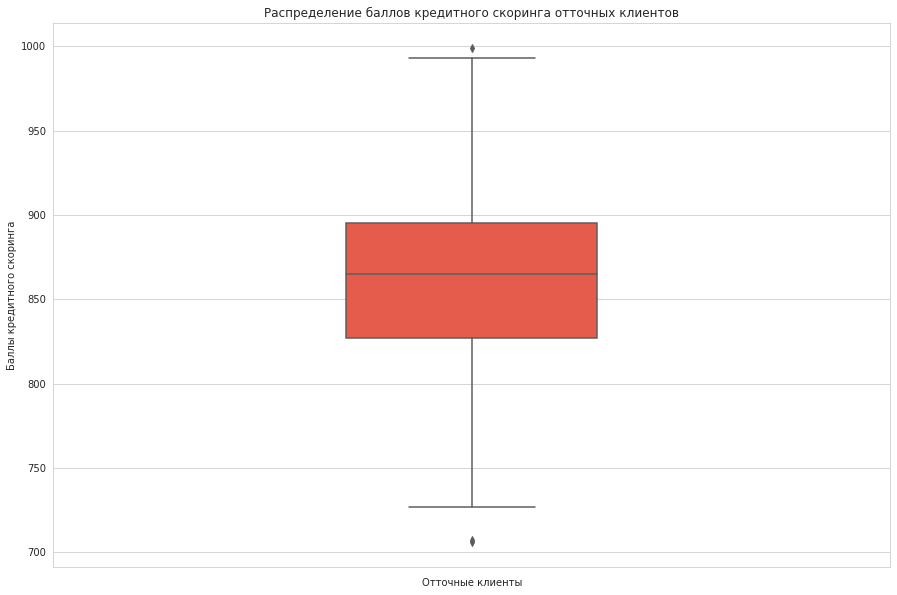

In [54]:
plt.figure(figsize=(15, 10))

ax = sns.boxplot(y='score', data=churn_clients, color='#ff4833', width=0.3)

plt.title('Распределение баллов кредитного cкоринга отточных клиентов')
plt.xlabel('Отточные клиенты')
plt.ylabel('Баллы кредитного скоринга')
plt.show()

Отлично, в наших данных только два вброса. Избавимся и от них.

In [55]:
churn_clients = churn_clients.query('725 <= score <= 990')

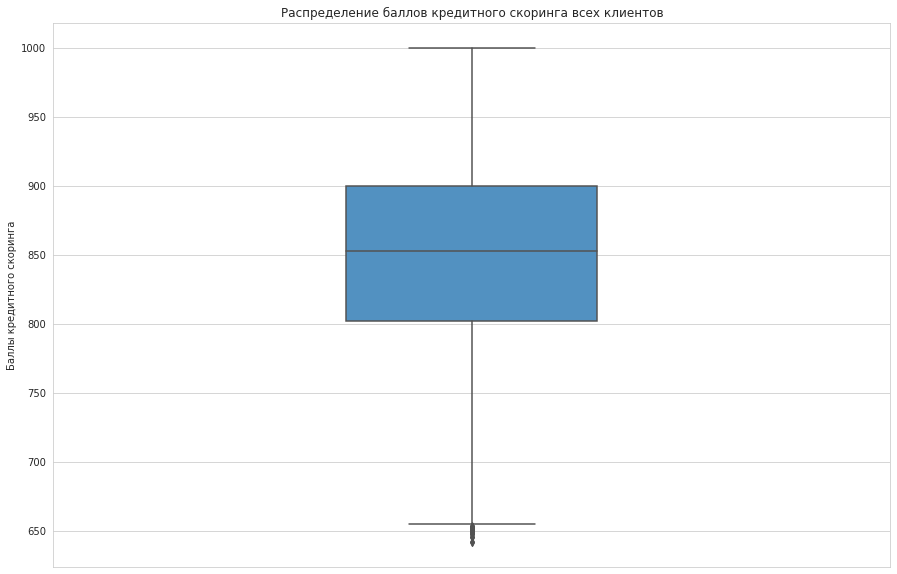

In [56]:
plt.figure(figsize=(15, 10))

ax = sns.boxplot(y='score', data=bank, color='#3f94d3', width=0.3)

plt.title('Распределение баллов кредитного cкоринга всех клиентов')
plt.ylabel('Баллы кредитного скоринга')
plt.show()

Теперь избавимся от вбросов и тут.

In [57]:
bank = bank.query('655 <= score')

Данные готовы к тесту.

Сформулируем нулевую и альтернативную гипотезы:

h0: *Среднее количество баллов кредитного скоринга отточных клиентов не превышает среднего значения по данным.*

h1: *Среднее количество баллов кредитного скоринга отточных клиентов больше среднего значения по данным.*

In [58]:
churn_score = churn_clients['score']
mean_score = bank['score'].mean()

alpha = 0.05

results = st.ttest_1samp(churn_score, mean_score, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

p-значение: 1.0351063909085997e-22
Отвергаем нулевую гипотезу


Значение `p-value` оказалось меньше, чем значение уровня статистической значимости.

Соответственно, есть все основания полагать, что **среднее количество баллов кредитного скоринга отточных клиентов больше среднего значения по всем данным**.

## Промежуточный итог - выделение признаков, влияющих на отток

Исходя из сделанных выводов в прошлых пунктах, приведём всю имеющуюся информацию об отточных клиентах. Из п.3.3.2 мы знаем, что:

1) *Кредитный скоринг*. Наибольшая категория отточных клиентов находится в интервале `от 860 до 900` баллов кредитного скоринга.

2) *Возраст*. Две категории отточных клиентов: возрастом `от 28 до 41` и `от 52 и до 59` лет.

3) *Текущий баланс*. Основной интервал текущего баланса отточных клиентов находится в пределах `от 250 тысяч до 500 тысяч`.

4) *Оценочный доход*. Отточные клиенты, в своей массе, имеют оценочный доход `от 90 тысяч до 125 тысяч`.

5) *Пол*. Клиенты-мужчины более склонны к оттоку, нежели клиенты-женщины. Средний уровень оттока в банке составляет `18.2 %`, клиенты-мужчины выше этого уровня примерно на `5 %`.

6) *Баллы собственности*. Лучше всего будет обратить внимание на клиентов с `3, 4 и 5` баллами собственности.

7) *Количество продуктов*.  Доля клиентов, пользующихся 4 продуктами, наиболее склонная к оттоку. Следом за ней группа клиентов с 3 продуктами.

8) *Наличие кредитной карты*. Наиболее склонны к оттоку клиенты, не пользующиеся кредитной картой банка, причем их отток выше общебанковского на 7 %.

9) *Активность*. Активные клиенты более склонны к оттоку.

Из п.3.4, можем сделать вывод, что:

1) Между значением оттока `churn` и столбцами баллов кредитного скоринга `score`, активности клиента `last_activity` и баллов собственности `equity` существует слабая прямая зависимость.

2) Обратную слабую зависимость между значением оттока `churn` и наличием кредитной карты `credit_card`.

3) Между значением оттока `churn` и количеством продуктов `products` существует умеренная прямая зависимость.

Также, исходя из проверки статистических гипотез в п.4:
* *нет оснований полагать*, что существует различие дохода между отточными и не отточными клиентами;
* *есть все основания считать*, что среднее количество баллов кредитного скоринга отточных клиентов больше среднего значения по всем клиентам банка.

Совмещая всю известную информацию, можно сделать такие приоретизации:

* Группа клиентов, пользующихся более чем 2 продуктами банка имеет наиболее высокий отток, учитывая корреляцию между значениями;
* Клиенты, имеющие более 2 баллов собственности более склонны к оттоку, нежели клиенты, имеющие 2 и меньше;
* У нас есть все основания полагать, что отточные клиенты имеют, в среднем, больше баллов кредитного скоринга, чем в среднем по банку, следовательно, это тоже необходимо учесть;
* Клиенты-мужчины, не пользующиеся кредитной картой, наиболее склонны к оттоку;
* Клиенты в возрасте от 29 до 41 и от 52 до 59, имеющие оценочный доход более 90 тысяч, также сильно склонны к оттоку.

## Сегментация клиентов

Теперь разделим наших отточных клиентов на сегменты:

* **Первый сегмент**. Наиболее отточные группы клиентов, состоящие из клиентов, возрастом от 29 до 41, имеющих более 2 баллов собственности и пользующихся более 2 продуктов банка.


* **Второй сегмент**. Сегмент с клиентами мужчинами, имеющими более 848 баллов кредитного скоринга и не пользующихся кредитной картой.


* **Третий сегмент**. Наименее отточная группа из клиентов в возрасте от 52 до 59 и имеющих оценочный доход более 90 тысяч.

In [59]:
first_segment = bank.query('29 <= age <= 41  & equity >= 3 & products >= 3')
print('Количество отточных клиентов:', first_segment[first_segment['churn']== 1]['user_id'].nunique())
print('Общее количество клиентов:', len(first_segment))
print('Что составляет', "{0:.1f}".format(first_segment[first_segment['churn']== 1]['user_id'].nunique() / len(first_segment) * 100), '% от общего числа клиентов сегмента')

Количество отточных клиентов: 248
Общее количество клиентов: 549
Что составляет 45.2 % от общего числа клиентов сегмента


In [60]:
second_segment = bank.query('score >= 848 & gender == "М" & credit_card == 0')
print('Количество отточных клиентов:', second_segment[second_segment['churn']== 1]['user_id'].nunique())
print('Общее количество клиентов:', len(second_segment))
print('Что составляет', "{0:.1f}".format(second_segment[second_segment['churn']== 1]['user_id'].nunique() / len(second_segment) * 100), '% от общего числа клиентов сегмента')

Количество отточных клиентов: 351
Общее количество клиентов: 826
Что составляет 42.5 % от общего числа клиентов сегмента


In [61]:
third_segment = bank.query('52 <= age <= 59 & est_salary >= 90000')
print('Количество отточных клиентов:', third_segment[third_segment['churn']== 1]['user_id'].nunique())
print('Общее количество клиентов:', len(third_segment))
print('Что составляет', "{0:.1f}".format(third_segment[third_segment['churn']== 1]['user_id'].nunique() / len(third_segment) * 100), '% от общего числа клиентов сегмента')

Количество отточных клиентов: 210
Общее количество клиентов: 732
Что составляет 28.7 % от общего числа клиентов сегмента


## Приоритизация сегментов

Говоря о приоретизации сегментов, стоит смотреть на убывание доли отточных клиентов:

1) Наиболее приоритетный сегмент - первый. Клиенты в возрасте от 29 до 41 лет, пользующиеся более чем 2мя продуктами банка, и имеющие более 2х баллов собственности. Это основная категория, внимание на которую стоит обратить.

2) Второй по приоритетности - второй сегмент. Клиенты-мужчины, имеющие более 848 баллов кредитного скоринга и не пользующиеся кредитной картой.

3) Последний по приоритетности - третий сегмент. Клиенты в возрасте от 52 до 59, имеющие оценочный доход от 90 тысяч.

## Рекоментации по сегментам

**Первый сегмент**. Клиенты в возрасте от 29 до 41 года составляют наибольшее число клиентов банка, при этом являясь наиболее отточной группой среди всех других по возрасту. 

То есть, это люди, имеющие оценочный доход примерно равный среднему (147 тысяч), и хранящие на балансе более миллиона, при этом, люди в этом возрасте, уже имеющие более 2х баллов собственности и пользующиеся 2мя продуктами банка. Уровень надежности данной группы не самый великий. Такие клиенты, обычно, очень активно распределяют свои финансы в разные структуры, однако, активность данной группы невелика (всего 55 % от общего числа активны). Скорее всего, такие клиенты появляются в банке/пользуются его услугами только для того, чтобы открыть новый вклад или закрыть действующий. Возможно, может помочь поднятие ставки по накопительным счетам/вкладам, чтобы вернуть клиента в свой актив.

**Второй сегмент**. Включает в себя клиентов-мужчин, имеющих более 848 баллов скоринга (что выше, чем среднее по банку) и не пользующиеся кредитной картой. 

Опять же, группа не очень активна (53 %), но имеет средний доход выше среднего по банку (190 тысяч), баллов собственности, в среднем, больше 3х. Баланс счёта в группе также выше среднего. Высокий уровень кредитного скоринга, данные клиенты считаются довольно надежными. Возможно, стоит провести акцию, связанную с кредитными картами, обзвонить, рассказать об условиях.

**Третий сегмент**. Клиенты в возрасте от 52 до 59, имеющие доход от 90000 тысяч. 

Данный сегмент клиентов зарабатывает выше среднего, на балансе счёта хранит также больше среднего клиента, довольно активно пользуется кредитной картой, при этом, у данной категории довольно низкое число пользования продуктами банка. Возможно, данная группа просто не знакома с продуктами и стоит ей об этом рассказать.

# Ссылка на презентацию

https://disk.yandex.ru/i/4HUe6V3j7_Tonw